In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import random_split

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from tqdm import tqdm

In [3]:
# Data agnostic
device = "cuda" if torch.cuda.is_available() else "cpu"

Make CNN for MNIST handwritten digit recognition

In [4]:
# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 10

In [5]:
# Load the MNIST dataset
trainDataset = datasets.MNIST(root='data/', train=True, transform=transforms.ToTensor(), download=True)
testDataset = datasets.MNIST(root='data/', train=False, transform=transforms.ToTensor())

# Create data loaders
trainLoader = torch.utils.data.DataLoader(dataset=trainDataset, batch_size=batch_size, shuffle=True)
testLoader = torch.utils.data.DataLoader(dataset=testDataset, batch_size=batch_size, shuffle=False)


100%|██████████| 9912422/9912422 [00:00<00:00, 942054953.08it/s]


Extracting data/MNIST\raw\train-images-idx3-ubyte.gz to data/MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 28475715.52it/s]


Extracting data/MNIST\raw\train-labels-idx1-ubyte.gz to data/MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 469160260.27it/s]


Extracting data/MNIST\raw\t10k-images-idx3-ubyte.gz to data/MNIST\raw



100%|██████████| 4542/4542 [00:00<00:00, 9128188.20it/s]

Extracting data/MNIST\raw\t10k-labels-idx1-ubyte.gz to data/MNIST\raw



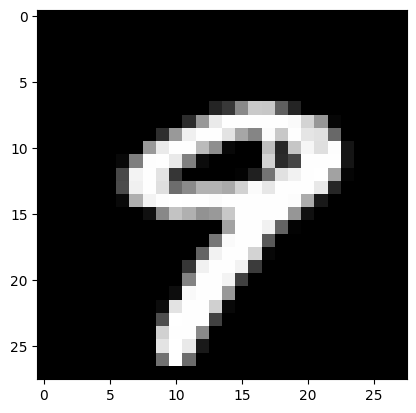

In [53]:
randInd = torch.randint(0,10,(1,))
image, label = testDataset[randInd.item()]
plt.imshow(image.squeeze(), cmap='gray')

CNN Model

In [7]:
class LeNet(nn.Module):
    def __init__(self, channels, classes):
        super(LeNet,self).__init__()
        
        # LeNet Architecture
        
        # First Block
        self.convBlock1 = nn.Conv2d(channels, 20, (5,5))
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d((2,2), (2,2))

        # Second Block
        self.convBlock2 = nn.Conv2d(20,50, (5,5))
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d((2,2), (2,2))

        # Fully Connected Layer
        self.fullyConnected1 = nn.Linear(800,500)
        self.relu3 = nn.ReLU()

        # Softmax for logit to predictions
        self.fullyConnected2 = nn.Linear(500,classes)
        self.logSoftmax = nn.LogSoftmax(dim=1)

    def forward(self,x):

        # First Block Pass
        x = self.maxpool1(self.relu1(self.convBlock1(x)))
        
        # Second Block Pass
        x = self.maxpool2(self.relu2(self.convBlock2(x)))
        
        # Flatten and pass to Fully Connected Layer
        x = self.relu3(self.fullyConnected1(torch.flatten(x,1)))

        # Softmax Pass
        x = self.fullyConnected2(x)
        output = self.logSoftmax(x)

        return output


Train Init

In [8]:
# HYPERPARAMETERS
lr = 1e-3
lr = 1e-6
# lr = 0.01
BATCH_SIZE = 32
epochs = 100

# Split data
trainSplit = 0.8
valSplit = 1-trainSplit

trainSamples = int(len(trainDataset) * trainSplit)
valSamples = int(round(len(trainDataset) * valSplit,0))

(trainData, valData) = random_split(trainDataset, [trainSamples, valSamples], generator=torch.Generator().manual_seed(42))

In [9]:
# Loaders
trainLoader = torch.utils.data.DataLoader(trainData, shuffle=True, batch_size=BATCH_SIZE)
valLoader = torch.utils.data.DataLoader(valData, batch_size=BATCH_SIZE)
testLoader = torch.utils.data.DataLoader(testDataset, batch_size=BATCH_SIZE)


# Batches
trainBatches = len(trainLoader.dataset) // BATCH_SIZE
valBatches = len(valLoader.dataset) // BATCH_SIZE

In [10]:
# Init

model = LeNet(1,len(trainData.dataset.classes)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
lossFn = nn.NLLLoss()

modelRes = {
    "train_loss" : [],
    "train_acc" : [],
    "val_loss" : [],
    "val_acc" : []
}

# Timing
startTime = time.time()

Training and Testing Loop

In [64]:
# Training Loop

for epoch in tqdm(range(epochs), desc="Training Epochs"):
    
    model.train()

     # Create inner tqdm progress bar for batches
    train_batch_progress = tqdm(trainLoader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch")

    totalTrainLoss = 0
    totalValLoss = 0

    trainCorrect = 0
    valCorrect = 0


    # Forward Pass
    for (x,y) in train_batch_progress:
        (x,y) = (x.to(device),y.to(device))

        # Loss
        pred = model(x)
        loss = lossFn(pred, y)
    
        # Optimizer Zero Grad
        optimizer.zero_grad()
    
        # Loss Backward
        loss.backward()

        # Optimizer Step 
        optimizer.step()

        totalTrainLoss += loss.item()
        totalTrainLoss = loss
        trainCorrect += (pred.argmax(1) == y).type(torch.float).sum().item() 
    
    model.eval()
    with torch.inference_mode():
        for (xVal, yVal) in valLoader:
            (xVal, yVal) = (xVal.to(device), yVal.to(device))

            # Forward Pass
            valPred = model(xVal)

            # Loss
            valLoss = lossFn(valPred, yVal)
            totalValLoss += valLoss.item()
            totalValLoss = valLoss

            valCorrect += (valPred.argmax(1) == yVal).type(torch.float).sum().item() 

    print(f'Train Loss: {totalTrainLoss} | Val Loss: {totalValLoss} | Val Correct: {valCorrect}')

        



Training Epochs:   1%|          | 1/100 [00:09<15:11,  9.21s/it]

Train Loss: 0.2529171109199524 | Val Loss: 0.3387524485588074 | Val Correct: 10571.0


Training Epochs:   2%|▏         | 2/100 [00:18<14:59,  9.18s/it]

Train Loss: 0.5280950665473938 | Val Loss: 0.20614312589168549 | Val Correct: 11471.0


Training Epochs:   3%|▎         | 3/100 [00:27<14:49,  9.17s/it]

Train Loss: 0.8333460688591003 | Val Loss: 0.16417691111564636 | Val Correct: 11211.0


Training Epochs:   4%|▍         | 4/100 [00:36<14:42,  9.19s/it]

Train Loss: 0.030068326741456985 | Val Loss: 0.06090026721358299 | Val Correct: 11629.0


Training Epochs:   5%|▌         | 5/100 [00:45<14:31,  9.17s/it]

Train Loss: 0.11224565654993057 | Val Loss: 0.2291586995124817 | Val Correct: 11392.0


Training Epochs:   6%|▌         | 6/100 [00:55<14:20,  9.15s/it]

Train Loss: 0.07230720669031143 | Val Loss: 0.15819086134433746 | Val Correct: 11530.0


Training Epochs:   7%|▋         | 7/100 [01:04<14:11,  9.15s/it]

Train Loss: 0.07913820445537567 | Val Loss: 0.1828167587518692 | Val Correct: 11257.0


Training Epochs:   8%|▊         | 8/100 [01:13<14:04,  9.18s/it]

Train Loss: 0.1196083053946495 | Val Loss: 0.13700784742832184 | Val Correct: 11126.0


Training Epochs:   9%|▉         | 9/100 [01:22<13:54,  9.17s/it]

Train Loss: 0.03485090285539627 | Val Loss: 1.8912642002105713 | Val Correct: 11376.0


Training Epochs:  10%|█         | 10/100 [01:31<13:45,  9.17s/it]

Train Loss: 0.03031325154006481 | Val Loss: 0.1278872936964035 | Val Correct: 11440.0


Training Epochs:  11%|█         | 11/100 [01:40<13:35,  9.16s/it]

Train Loss: 0.07062137871980667 | Val Loss: 0.7991161346435547 | Val Correct: 11498.0


Training Epochs:  12%|█▏        | 12/100 [01:49<13:25,  9.15s/it]

Train Loss: 0.3049714267253876 | Val Loss: 2.4100940227508545 | Val Correct: 11321.0


Training Epochs:  13%|█▎        | 13/100 [01:59<13:16,  9.15s/it]

Train Loss: 0.11491122841835022 | Val Loss: 0.2768561840057373 | Val Correct: 11062.0


Training Epochs:  14%|█▍        | 14/100 [02:08<13:06,  9.14s/it]

Train Loss: 0.18851664662361145 | Val Loss: 0.20048925280570984 | Val Correct: 11486.0


Training Epochs:  15%|█▌        | 15/100 [02:17<12:57,  9.15s/it]

Train Loss: 0.10950367897748947 | Val Loss: 0.19008128345012665 | Val Correct: 11290.0


Training Epochs:  16%|█▌        | 16/100 [02:26<12:49,  9.16s/it]

Train Loss: 0.10413263738155365 | Val Loss: 0.116792693734169 | Val Correct: 11369.0


Training Epochs:  17%|█▋        | 17/100 [02:35<12:40,  9.16s/it]

Train Loss: 0.14606709778308868 | Val Loss: 0.22238636016845703 | Val Correct: 11468.0


Training Epochs:  18%|█▊        | 18/100 [02:44<12:30,  9.15s/it]

Train Loss: 0.1268460601568222 | Val Loss: 0.3094710409641266 | Val Correct: 11306.0


Training Epochs:  19%|█▉        | 19/100 [02:54<12:20,  9.14s/it]

Train Loss: 0.1408599466085434 | Val Loss: 0.24537405371665955 | Val Correct: 11465.0


Training Epochs:  20%|██        | 20/100 [03:03<12:09,  9.12s/it]

Train Loss: 0.08032704889774323 | Val Loss: 0.12454605102539062 | Val Correct: 11463.0


Training Epochs:  21%|██        | 21/100 [03:12<12:00,  9.12s/it]

Train Loss: 0.1620122641324997 | Val Loss: 0.6134101152420044 | Val Correct: 11447.0


Training Epochs:  22%|██▏       | 22/100 [03:21<11:51,  9.12s/it]

Train Loss: 0.07960241287946701 | Val Loss: 0.13140372931957245 | Val Correct: 11582.0


Training Epochs:  23%|██▎       | 23/100 [03:30<11:43,  9.13s/it]

Train Loss: 0.05886903405189514 | Val Loss: 0.1415274739265442 | Val Correct: 11178.0


Training Epochs:  24%|██▍       | 24/100 [03:39<11:36,  9.16s/it]

Train Loss: 0.1543637067079544 | Val Loss: 0.11508173495531082 | Val Correct: 11391.0


Training Epochs:  25%|██▌       | 25/100 [03:48<11:26,  9.15s/it]

Train Loss: 0.48525476455688477 | Val Loss: 0.19594120979309082 | Val Correct: 11510.0


Training Epochs:  26%|██▌       | 26/100 [03:58<11:18,  9.17s/it]

Train Loss: 0.10142607986927032 | Val Loss: 0.20122817158699036 | Val Correct: 11334.0


Training Epochs:  27%|██▋       | 27/100 [04:07<11:15,  9.26s/it]

Train Loss: 0.18328233063220978 | Val Loss: 0.2009509801864624 | Val Correct: 11162.0


Training Epochs:  28%|██▊       | 28/100 [04:16<11:10,  9.31s/it]

Train Loss: 0.1291216015815735 | Val Loss: 0.1981608271598816 | Val Correct: 11332.0


Training Epochs:  29%|██▉       | 29/100 [04:26<11:05,  9.37s/it]

Train Loss: 0.06038818135857582 | Val Loss: 0.19987383484840393 | Val Correct: 11385.0


Training Epochs:  30%|███       | 30/100 [04:35<10:57,  9.39s/it]

Train Loss: 0.1295640766620636 | Val Loss: 0.19499263167381287 | Val Correct: 11366.0


Training Epochs:  31%|███       | 31/100 [04:45<10:47,  9.38s/it]

Train Loss: 0.2721027433872223 | Val Loss: 0.49447423219680786 | Val Correct: 10527.0


Training Epochs:  32%|███▏      | 32/100 [04:54<10:39,  9.40s/it]

Train Loss: 0.2195809781551361 | Val Loss: 0.21331745386123657 | Val Correct: 11364.0


Training Epochs:  33%|███▎      | 33/100 [05:04<10:30,  9.40s/it]

Train Loss: 0.06210826709866524 | Val Loss: 0.2618364095687866 | Val Correct: 11160.0


Training Epochs:  34%|███▍      | 34/100 [05:13<10:17,  9.36s/it]

Train Loss: 0.20882059633731842 | Val Loss: 0.2717492878437042 | Val Correct: 10906.0


Training Epochs:  35%|███▌      | 35/100 [05:22<10:04,  9.30s/it]

Train Loss: 3.8912596702575684 | Val Loss: 0.27812865376472473 | Val Correct: 11385.0


Training Epochs:  36%|███▌      | 36/100 [05:31<09:52,  9.26s/it]

Train Loss: 0.19533219933509827 | Val Loss: 0.2152966558933258 | Val Correct: 11207.0


Training Epochs:  37%|███▋      | 37/100 [05:41<09:46,  9.31s/it]

Train Loss: 0.13943889737129211 | Val Loss: 0.19379660487174988 | Val Correct: 11408.0


Training Epochs:  38%|███▊      | 38/100 [05:50<09:40,  9.36s/it]

Train Loss: 0.1314498782157898 | Val Loss: 0.11941708624362946 | Val Correct: 11382.0


Training Epochs:  39%|███▉      | 39/100 [06:00<09:31,  9.37s/it]

Train Loss: 0.09643476456403732 | Val Loss: 0.15613868832588196 | Val Correct: 11391.0


Training Epochs:  40%|████      | 40/100 [06:09<09:27,  9.45s/it]

Train Loss: 0.03252003341913223 | Val Loss: 0.18845677375793457 | Val Correct: 11299.0


Training Epochs:  41%|████      | 41/100 [06:19<09:16,  9.44s/it]

Train Loss: 0.07650067657232285 | Val Loss: 0.11485687643289566 | Val Correct: 11399.0


Training Epochs:  42%|████▏     | 42/100 [06:28<09:06,  9.42s/it]

Train Loss: 0.0 | Val Loss: 0.11271077394485474 | Val Correct: 11423.0


Training Epochs:  43%|████▎     | 43/100 [06:37<08:57,  9.43s/it]

Train Loss: 0.048347700387239456 | Val Loss: 0.15294024348258972 | Val Correct: 11331.0


Training Epochs:  44%|████▍     | 44/100 [06:47<08:50,  9.47s/it]

Train Loss: 0.0589110367000103 | Val Loss: 0.2382291555404663 | Val Correct: 11375.0


Training Epochs:  45%|████▌     | 45/100 [06:56<08:41,  9.48s/it]

Train Loss: 0.006646567489951849 | Val Loss: 0.20645618438720703 | Val Correct: 11359.0


Training Epochs:  46%|████▌     | 46/100 [07:06<08:32,  9.48s/it]

Train Loss: 0.09923184663057327 | Val Loss: 0.25867700576782227 | Val Correct: 10960.0


Training Epochs:  47%|████▋     | 47/100 [07:15<08:22,  9.49s/it]

Train Loss: 0.15814180672168732 | Val Loss: 0.2604697346687317 | Val Correct: 11225.0


Training Epochs:  48%|████▊     | 48/100 [07:25<08:19,  9.61s/it]

Train Loss: 0.03582525625824928 | Val Loss: 0.235571026802063 | Val Correct: 11036.0


Training Epochs:  49%|████▉     | 49/100 [07:35<08:08,  9.58s/it]

Train Loss: 0.6274030804634094 | Val Loss: 0.5465391874313354 | Val Correct: 10340.0


Training Epochs:  50%|█████     | 50/100 [07:44<07:53,  9.47s/it]

Train Loss: 0.32545846700668335 | Val Loss: 0.3184519410133362 | Val Correct: 10928.0


Training Epochs:  51%|█████     | 51/100 [07:54<07:47,  9.54s/it]

Train Loss: 0.15222783386707306 | Val Loss: 0.12407941371202469 | Val Correct: 11215.0


Training Epochs:  52%|█████▏    | 52/100 [08:04<07:48,  9.75s/it]

Train Loss: 0.19835825264453888 | Val Loss: 0.12989002466201782 | Val Correct: 11306.0


Training Epochs:  53%|█████▎    | 53/100 [08:14<07:35,  9.70s/it]

Train Loss: 0.36778104305267334 | Val Loss: 0.1280573010444641 | Val Correct: 11413.0


Training Epochs:  54%|█████▍    | 54/100 [08:23<07:20,  9.58s/it]

Train Loss: 0.12798672914505005 | Val Loss: 0.21129636466503143 | Val Correct: 10998.0


Training Epochs:  55%|█████▌    | 55/100 [08:32<07:07,  9.50s/it]

Train Loss: 0.04382358491420746 | Val Loss: 0.3118146061897278 | Val Correct: 11108.0


Training Epochs:  56%|█████▌    | 56/100 [08:41<06:55,  9.43s/it]

Train Loss: 0.09976132214069366 | Val Loss: 0.20233795046806335 | Val Correct: 11138.0


Training Epochs:  57%|█████▋    | 57/100 [08:51<06:43,  9.39s/it]

Train Loss: 0.09464462101459503 | Val Loss: 0.19417017698287964 | Val Correct: 11432.0


Training Epochs:  58%|█████▊    | 58/100 [09:00<06:36,  9.44s/it]

Train Loss: 0.2641077935695648 | Val Loss: 0.31980520486831665 | Val Correct: 11020.0


Training Epochs:  59%|█████▉    | 59/100 [09:09<06:23,  9.35s/it]

Train Loss: 0.26402735710144043 | Val Loss: 0.3817942142486572 | Val Correct: 10760.0


Training Epochs:  60%|██████    | 60/100 [09:19<06:11,  9.28s/it]

Train Loss: 0.22682321071624756 | Val Loss: 0.29814761877059937 | Val Correct: 11016.0


Training Epochs:  61%|██████    | 61/100 [09:28<06:00,  9.24s/it]

Train Loss: 0.2824069857597351 | Val Loss: 0.11246617138385773 | Val Correct: 11053.0


Training Epochs:  62%|██████▏   | 62/100 [09:37<05:50,  9.22s/it]

Train Loss: 0.12243583798408508 | Val Loss: 0.12498055398464203 | Val Correct: 11364.0


Training Epochs:  63%|██████▎   | 63/100 [09:47<05:48,  9.43s/it]

Train Loss: 0.1402970552444458 | Val Loss: 0.3069201111793518 | Val Correct: 11090.0


Training Epochs:  64%|██████▍   | 64/100 [09:56<05:36,  9.36s/it]

Train Loss: 0.2638929784297943 | Val Loss: 0.1257731020450592 | Val Correct: 11043.0


Training Epochs:  65%|██████▌   | 65/100 [10:06<05:30,  9.43s/it]

Train Loss: 0.20377610623836517 | Val Loss: 0.21336525678634644 | Val Correct: 11205.0


Training Epochs:  66%|██████▌   | 66/100 [10:15<05:22,  9.49s/it]

Train Loss: 0.3672432005405426 | Val Loss: 0.14220494031906128 | Val Correct: 11305.0


Training Epochs:  67%|██████▋   | 67/100 [10:25<05:13,  9.49s/it]

Train Loss: 0.18763107061386108 | Val Loss: 0.23597951233386993 | Val Correct: 10939.0


Training Epochs:  68%|██████▊   | 68/100 [10:34<05:00,  9.39s/it]

Train Loss: 0.21878638863563538 | Val Loss: 0.3029080331325531 | Val Correct: 11083.0


Training Epochs:  69%|██████▉   | 69/100 [10:43<04:52,  9.44s/it]

Train Loss: 0.258541077375412 | Val Loss: 0.34670567512512207 | Val Correct: 10788.0


Training Epochs:  70%|███████   | 70/100 [10:54<04:50,  9.69s/it]

Train Loss: 0.19696322083473206 | Val Loss: 0.34856879711151123 | Val Correct: 10837.0


Training Epochs:  71%|███████   | 71/100 [11:03<04:36,  9.53s/it]

Train Loss: 0.12828953564167023 | Val Loss: 0.19524261355400085 | Val Correct: 11221.0


Training Epochs:  72%|███████▏  | 72/100 [11:12<04:26,  9.54s/it]

Train Loss: 0.11584632843732834 | Val Loss: 0.059647150337696075 | Val Correct: 11173.0


Training Epochs:  73%|███████▎  | 73/100 [11:22<04:16,  9.51s/it]

Train Loss: 0.291568785905838 | Val Loss: 0.1859436333179474 | Val Correct: 11104.0


Training Epochs:  74%|███████▍  | 74/100 [11:31<04:04,  9.39s/it]

Train Loss: 0.46638017892837524 | Val Loss: 0.4882700443267822 | Val Correct: 10313.0


Training Epochs:  75%|███████▌  | 75/100 [11:40<03:52,  9.32s/it]

Train Loss: 0.2807011008262634 | Val Loss: 0.4157498776912689 | Val Correct: 10746.0


Training Epochs:  76%|███████▌  | 76/100 [11:49<03:43,  9.30s/it]

Train Loss: 0.33433157205581665 | Val Loss: 0.48734229803085327 | Val Correct: 10145.0


Training Epochs:  77%|███████▋  | 77/100 [11:59<03:34,  9.34s/it]

Train Loss: 0.33864957094192505 | Val Loss: 0.3713238835334778 | Val Correct: 10460.0


Training Epochs:  78%|███████▊  | 78/100 [12:08<03:25,  9.32s/it]

Train Loss: 0.1526155173778534 | Val Loss: 0.13720721006393433 | Val Correct: 10878.0


Training Epochs:  79%|███████▉  | 79/100 [12:17<03:15,  9.30s/it]

Train Loss: 0.24426144361495972 | Val Loss: 0.062284089624881744 | Val Correct: 11151.0


Training Epochs:  80%|████████  | 80/100 [12:26<03:03,  9.20s/it]

Train Loss: 0.18446190655231476 | Val Loss: 0.4230034351348877 | Val Correct: 10468.0


Training Epochs:  81%|████████  | 81/100 [12:36<02:54,  9.20s/it]

Train Loss: 0.06499162316322327 | Val Loss: 0.1477273404598236 | Val Correct: 11181.0


Training Epochs:  82%|████████▏ | 82/100 [12:45<02:46,  9.22s/it]

Train Loss: 0.108253613114357 | Val Loss: 0.20571522414684296 | Val Correct: 11141.0


Training Epochs:  83%|████████▎ | 83/100 [12:54<02:38,  9.29s/it]

Train Loss: 0.2917086184024811 | Val Loss: 0.1299826204776764 | Val Correct: 11104.0


Training Epochs:  84%|████████▍ | 84/100 [13:04<02:30,  9.41s/it]

Train Loss: 0.22054487466812134 | Val Loss: 0.2838183045387268 | Val Correct: 11238.0


Training Epochs:  85%|████████▌ | 85/100 [13:14<02:22,  9.48s/it]

Train Loss: 0.26316577196121216 | Val Loss: 0.38868001103401184 | Val Correct: 10911.0


Training Epochs:  86%|████████▌ | 86/100 [13:23<02:12,  9.45s/it]

Train Loss: 0.12712639570236206 | Val Loss: 0.22756001353263855 | Val Correct: 11190.0


Training Epochs:  87%|████████▋ | 87/100 [13:33<02:04,  9.59s/it]

Train Loss: 0.138389453291893 | Val Loss: 0.12754058837890625 | Val Correct: 11251.0


Training Epochs:  88%|████████▊ | 88/100 [13:44<01:58,  9.90s/it]

Train Loss: 0.12380362302064896 | Val Loss: 0.27395540475845337 | Val Correct: 11047.0


Training Epochs:  89%|████████▉ | 89/100 [13:53<01:46,  9.69s/it]

Train Loss: 0.3425276279449463 | Val Loss: 0.3670960068702698 | Val Correct: 10726.0


Training Epochs:  90%|█████████ | 90/100 [14:02<01:36,  9.66s/it]

Train Loss: 0.3433966636657715 | Val Loss: 0.5185450911521912 | Val Correct: 10411.0


Training Epochs:  91%|█████████ | 91/100 [14:12<01:25,  9.55s/it]

Train Loss: 0.42070162296295166 | Val Loss: 0.5189907550811768 | Val Correct: 10237.0


Training Epochs:  92%|█████████▏| 92/100 [14:21<01:15,  9.46s/it]

Train Loss: 0.3275339603424072 | Val Loss: 0.37915605306625366 | Val Correct: 10876.0


Training Epochs:  93%|█████████▎| 93/100 [14:30<01:06,  9.45s/it]

Train Loss: 0.2738719582557678 | Val Loss: 0.37140679359436035 | Val Correct: 10796.0


Training Epochs:  94%|█████████▍| 94/100 [14:40<00:57,  9.55s/it]

Train Loss: 0.31545281410217285 | Val Loss: 0.28046026825904846 | Val Correct: 11138.0


Training Epochs:  95%|█████████▌| 95/100 [14:50<00:47,  9.52s/it]

Train Loss: 0.3385157585144043 | Val Loss: 0.2549605965614319 | Val Correct: 10726.0


Training Epochs:  96%|█████████▌| 96/100 [14:59<00:38,  9.58s/it]

Train Loss: 0.3138388693332672 | Val Loss: 0.27362674474716187 | Val Correct: 10673.0


Training Epochs:  97%|█████████▋| 97/100 [15:09<00:28,  9.49s/it]

Train Loss: 0.31385183334350586 | Val Loss: 0.478374183177948 | Val Correct: 10241.0


Training Epochs:  98%|█████████▊| 98/100 [15:18<00:18,  9.43s/it]

Train Loss: 0.2184602916240692 | Val Loss: 0.3767787218093872 | Val Correct: 10919.0


Training Epochs:  99%|█████████▉| 99/100 [15:27<00:09,  9.38s/it]

Train Loss: 0.38901787996292114 | Val Loss: 0.14571639895439148 | Val Correct: 10838.0


Training Epochs: 100%|██████████| 100/100 [15:37<00:00,  9.37s/it]

Train Loss: 0.3876250386238098 | Val Loss: 0.21892422437667847 | Val Correct: 11234.0


Predicted Digit: 8
Predicted Digit: 0
Predicted Digit: 5
Predicted Digit: 0
Predicted Digit: 6
Predicted Digit: 2
Predicted Digit: 9
Predicted Digit: 8
Predicted Digit: 5
Predicted Digit: 1
Predicted Digit: 6
Predicted Digit: 8
Predicted Digit: 1
Predicted Digit: 4
Predicted Digit: 6
Predicted Digit: 1
Predicted Digit: 3
Predicted Digit: 4
Predicted Digit: 2
Predicted Digit: 4


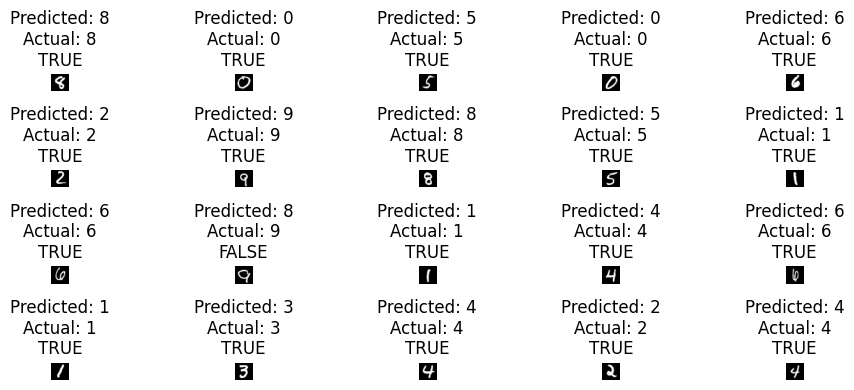

In [14]:
n = 20
cols = 5
fig, axs = plt.subplots(nrows=n//cols, ncols=cols, figsize=(10, 4))


for i in range(n):

    randInd = torch.randint(0,len(testDataset),(1,))
    image, label = testDataset[randInd.item()]

    axs[i // 5, i % 5].imshow(image.squeeze(), cmap="gray")
    axs[i // 5, i % 5].axis("off")

    model.eval()
    with torch.inference_mode():
        prediction = model(image.unsqueeze(0).to(device))


    predicted_class = torch.argmax(prediction).item()
    # print("Ground truth label:", label)
    print(f"Predicted Digit: {predicted_cl
          iass}")

    res = ""
    if label == predicted_class:
        res = "TRUE"
        # print("TRUE")
    else:
        res = "FALSE"
        # print("FALSE")
   
    axs[i // 5, i % 5].set_title(f"Predicted: {predicted_class}\nActual: {label}\n{res}")

plt.tight_layout()
plt.show()

Save Model

In [114]:
# Save Model
import os

baseName = "HDR.pth"
i = 1
fileName = baseName

while os.path.exists(fileName):
    fileName = f"{os.path.splitext(baseName)[0]}_{i}.pth"
    i += 1

torch.save(model.state_dict(), fileName)

Load Model

In [13]:
model = LeNet(1,10)
state_dict = torch.load("HDR.pth", torch.device(device))
model.load_state_dict(state_dict)
model = model.to(device)

def HDR(x):
    print("CALLED HDR")
    model(x)

In [17]:
x = "data:image/png;base64,iVBORw0KGgoAAAANSUh"
x.split(",")[1]

'iVBORw0KGgoAAAANSUh'

torch.Size([1, 28, 28])


8

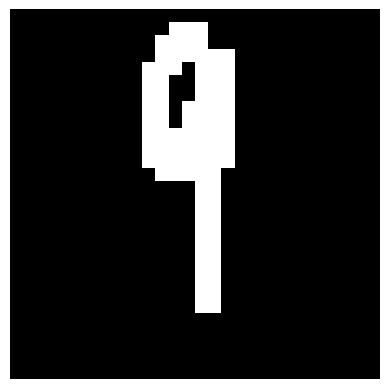

In [20]:
import base64
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import torchvision.transforms
from torchvision.transforms import Resize, ToTensor, Grayscale

x = "iVBORw0KGgoAAAANSUhEUgAAAswAAAFwCAYAAACsMS2JAAAAAXNSR0IArs4c6QAAIABJREFUeF7t3V/sbelZF/DnKdSEpG06mBCgVeZcgKVFLQJqY6UziTdG0WhCTLW1c26MgWgCwZiY4EwlJkQQgobGuzmxXBCD4QLu57TWQITYGgQaajIHLBRjsJOWBhNLH7PoPp3pb/Zee+291793rc9OJnNx1nrf5/0865zz/e2z1rsyfAgQIECAAAECBAgQOCmQbAgQIECAAAECBAgQOC0gMLs6CBAgQIAAAQIECPQICMwuDwIECBAgQIAAAQICs2uAAAECBAgQIECAwHUCvmG+zs1ZBAgQIECAAAECOxEQmHfSaMskQIAAAQIECBC4TkBgvs7NWQQIECBAgAABAjsREJh30mjLJECAAAECBAgQuE5AYL7OzVkECBAgQIAAAQI7ERCYd9JoyyRAgAABAgQIELhOQGC+zs1ZBAgQIECAAAECOxEQmHfSaMskQIAAAQIECBC4TkBgvs7NWQQIECBAgAABAjsREJh30mjLJECAAAECBAgQuE5AYL7OzVkECBAgQIAAAQI7ERCYd9JoyyRAgAABAgQIELhOQGC+zs1ZBAgQIECAAAECOxEQmHfSaMskQIAAAQIECBC4TkBgvs7NWQQIECBAgAABAjsREJh30mjLJECAAAECBAgQuE5AYL7OzVkECBAgQIAAAQI7ERCYd9JoyyRAgAABAgQIELhOQGC+zs1ZBAgQIECAAAECOxEQmHfSaMskQIAAAQIECBC4TkBgvs7NWQQIECBAgAABAjsREJh30mjLJECAAAECBAgQuE5AYL7OzVkECOxUoKqeioh/FRHfcSHBxyPir2bmowvPczgBAgQILCwgMC/cANMTILB+gUNIfldEPDdCtQ8i4v2C8wiShiBAgMBMAgLzTNCmIUCgLYGRQ/Kxxf/HiPihzPxvbcmolgABAvsTEJj313MrJkCgR6CqXoiI7raLuT6/FBH/IDM/NteE5iFAgACBywQE5su8HE2AwEYFqurJiPhoRLxxgSX+QUT8QGZ+YIG5TUmAAAECZwQEZpcIAQK7F6iqZ0e6P/lWyw9HxA9mZvd/HwIECBBYiYDAvJJGKIMAgfkFDt8qP3/hLRjdLhfdg3u/mZnd/3s/h3uh33eYo/sWe8inu03j72XmJ4Yc7BgCBAgQmFZAYJ7W1+gECKxU4BBku/uVh3wuCsnHBnxFcP47EfFVAyb9vYj4drtpDJByCAECBCYWEJgnBjY8AQLrE7jgwb7uQbyfGPJN8tBVVtVfiYh/GxFvGXDOJyPiLwvNA6QcQoAAgQkFBOYJcQ1NgMC6BA63YPxCRHztmcq6b5TvZ+bDqVZQVd/ZbSsXEd3/z326Ws7e/nFuEL9OgAABAtcJCMzXuTmLAIHGBKrqmYjo7lc+93mYmU+fO2isX6+q74mIHx1wm8Zzmfn+seY1DgECBAgMFxCYh1s5kgCBRgWqqgvKXWA+91kklFbVV0fEfx5wm0b3jXf3bbPXa5/rpF8nQIDAiAIC84iYhiJAYF0CF+yC8fsR8V1T3oIxRKaqfjgi/umZYz+Wmd86ZDzHECBAgMA4AgLzOI5GIUBgZQIX3IKxqgB6qLvbF7pvC7oHmXl/ZeTKIUCAwGYFBObNttbCCOxXoKq6N/a9fYDAKh+mO2xB191GIjQPaKJDCBAgMLWAwDy1sPEJEJhVoKo+tYZdMG5d9MBXdfum+VZo5xMgQGCAgMA8AMkhBAisX+CC+5WbCZmHNf3smW/Lm1nP+q8iFRIgQOC4gMDsyiBAoHmBC8LyKm/B6GvAYW3dq7Wf6zluVfdhN39BWQABAgTuCAjMLgkCBJoWOATKF88s4qWI+FtL74JxLfTA0Pw/MvMbr53DeQQIECBwWkBgdnUQINCswOHhuBfOLOBRZt5rdpGHwgeG5qdb/aGg9f6onwCBbQsIzNvur9UR2KzAwLA861v7psYeEJo38cPB1I7GJ0CAwKUCAvOlYo4nQGBxgYFheZG39k2NM+BBQA8BTt0E4xMgsDsBgXl3LbdgAm0LDHwhSXMP913Slap6Z0T8XES88cR5bs24BNSxBAgQOCMgMLtECBBoRqCqupd5PHOm4F2ExTPfsn8uM1/XTGMVSoAAgZULCMwrb5DyCBD4okBVdQ/3PSUsvyxw5geIT2TmN7l+CBAgQOB2AYH5dkMjECAwsUBVddvG9b0muqtgF98sv5L6cD/zRyLiTSda8E8y80cnbo/hCRAgsHkBgXnzLbZAAm0LDAjLjyKiu2f5Ydsrva76qvruiPgPPWd/V2b+/HWj335WVf1KRLztMNKvZuafvn1UIxAgQGBeAYF5Xm+zESBwgcCAB/x2HZYfU1bVL0fEt52g/b2IeEdmfuIC+lEOPYTlb7kz2H8XmkfhNQgBAjMKCMwzYpuKAIHhAgO2jtvUHsvDZV595OHWjA9FxJ88Mc5vZeY33DLHNedWVR07LzP93XMNqHMIEFhMwB9ai9GbmACBPoEzt2L8bmZ+HcGXBaqqey32L0TEHz/h8huZ+afmMut7ZbnAPFcXzEOAwFgCAvNYksYhQGA0gTM7Ynib3Qnpqvrrh/2ZT/XiT2TmJ0drVM9AVfUbEdGF+Fd9BOY5OmAOAgTGFBCYx9Q0FgECNwtU1bMR8VzPQLvbDeMS1Kr6gYj4kRPnvDczf+qS8a459kwNITBfo+ocAgSWFBCYl9Q3NwECXyYw4L5lYXnANVNVvxMRx25Z+e3MfPOAIa4+ZMC33P87M7/m6gmcSIAAgQUEBOYF0E1JgMCrBfrueT0c/Vxmvp/deYGeHzy+kJlfcX6E644YcB91N/CDzLx/3QzOIkCAwDICAvMy7mYlQOAVAlX1xyKi+1b01ANrdsS44IpZ6oG7qvrNnp06Hq/ADz4X9NKhBAisQ0BgXkcfVEFg1wJV9esR8ZYTCB7yu+LqmHtLt6r67Yj4+gGldi+ZeTDgOIcQIEBgNQIC82paoRAC+xSoqu+MiG4P4VMf9y1fcWnMGZir6l9HxPcPLFM/B0I5jACB9QgIzOvphUoI7FKgqrqw3IXmY5+/kZk/t0uYGxc9V2Ae8KDm3ZXcy8zuDY0+BAgQaEZAYG6mVQolsD2BqvqeiPjJEyubfEeH7Ym+vKJTgTkiXp+Zvz/G2q8Iy7aUGwPeGAQIzC4gMM9ObkICBDqBqvrqiPhERHT/v/v5g4h4c2b+H1qXC1TVWyPiV4+cWZn5mstHfPUZA3Y1OTbNS5n5xBjzG4MAAQJzCgjMc2qbiwCBLwlUVffNcvcN87HP92bmB3BdJ1BV74mIDx45+3cy803XjfrlZ1XVpyLia0+M9emIOBaM7XYyBr4xCBCYXUBgnp3chAQInHnQ78OZ+S5K1wtU1Y9FxPcdGeHHM3Pow3knC6iqj0bE23sq7HbBeObIr9tS7vq2OpMAgQUFBOYF8U1NYK8CZx70e1dmfnivNmOsu6oeRsSxHzpufjV2VXVB+PmeOp+OiPcJzGN00hgECKxFQGBeSyfUQWAnAmce9PtAZn7vTigmW2ZVfaZ7uO/IBG/LzF+7duIB9y3/0TfIVfVCRDx1ZB5byl2L7zwCBBYVEJgX5Tc5gX0JHB70+2REfNWRlXcP+H2jB/1uuyaq6nUR8dkjo3w2M99wy+g9Qbgb9ksvmOnZocOWcrc0wLkECCwmIDAvRm9iAvsTqKr/EhHfcWLlHvQb6ZKoqv8UEe+8M9xPZ+a7r52iqrrbMI7dl9wN+WW7X8y1B/S1a3EeAQIELhUQmC8VczwBAlcJVNWfjYiPnTjZg35XqR4/qaq+ISJ+OCL+2uHWjI9ExHsy8zevmWbIfcuZ2d033W0X+GREvHhkHq84vwbfOQQIrEJAYF5FGxRBYPsCVfUTEfGPT6zUg34TXQLdLRq3vKhkwH3L9zOz2xXjjz49LzOxpdxEPTYsAQLTCwjM0xubgcDuBc6Erl/KzD+/e6SVAlRV921x963xsc+DzLz/yl+oqmcj4rkjB7/q2JUuWVkECBB4lYDA7KIgQGBygZ4Q1c39TZnZvfHPZ2UCZ8Ly0VssenptD+aV9Vc5BAgMFxCYh1s5kgCBKwTOfLssRF1hOscpZ37I6Uo4ukVcVf1CRPzFIzV+2a0bc6zBHAQIEBhLQGAeS9I4BAgcFTgTvGwztsLrpuc+5MfVngy/VfW/IuJrjizLHswr7LWSCBAYJiAwD3NyFAECVwj4dvkKtIVPGRCWP5aZ33qqzJ49mF9/y8OHC7OYngCBnQsIzDu/ACyfwJQCvl2eUnf8sQfsiPG7mfl1PWH5rRHxq0d+/QuZ+RXjV2xEAgQIzCMgMM/jbBYCuxPw7XJbLT/0q3s5ybFXWneLObuPclW9JyI+eGTlZ89tS0u1BAjsTUBg3lvHrZfATAJnXqPs3uWZ+jB0mjP96oY5ew9yVf1YRHzfkTl/PDO/f2gtjiNAgMDaBATmtXVEPQQ2ItBzL6udMVbW4zHCcrekqure9veuI8t7b2b+1MqWrRwCBAgMFhCYB1M5kACBoQJnHhzz7fJQyBmOu3b7uGOlVdVnDq/ivvvLb8vMX5thOaYgQIDAJAIC8ySsBiWwb4GeEOZe1hVdGgN2xBj8rwFVdeqBv89m5htWtGylECBA4GIBgfliMicQIHBOwO0Y54SW//UBYflhZj49tNKeB/4+lJmnHiQcOrzjCBAgsKiAwLwov8kJbE+gb3eMzPRnzgpaPmD7uIvCcrckD/ytoLFKIEBgMgF/eU1Ga2AC+xRwO8a6+z7G9nHHVuiBv3X3XXUECNwmIDDf5udsAgTuCPTsuDD4flio0wlU1YsR8WTPDGe3jzsRmD3wN13bjEyAwMICAvPCDTA9gS0JnPmnfrtjLNzsCcOyB/4W7q3pCRCYVkBgntbX6AR2JeB2jPW2e8zt4+6u0gN/6+27yggQGEdAYB7H0SgECHzxwa+PRsTbj2C4HWPBK2TAjhg39ccDfws219QECMwiIDDPwmwSAvsQ6NlO7qr7YvehNu0qB+yIcfPe2D23enjD37TtNToBAjMJCMwzQZuGwNYFeoLZ5zPztVtf/1rXd+a11zeH5W7dPT8oecPfWi8MdREgcJGAwHwRl4MJEDgl0PPP/i9l5hPk5heYKSyfeuDvC5n5FfOv2owECBAYX0BgHt/UiAR2KdDzUNmDzLy/S5QFFz3lQ36vXFbPD0qfy8zXLUhgagIECIwmIDCPRmkgAvsW6AloNz1Qtm/V61Y/4CG/0e4p7+n7z2Tmd1+3AmcRIEBgXQIC87r6oRoCzQr0/PP/aOGsWZwZCx8Qlkf9AcYPSjM211QECCwmIDAvRm9iAtsSOPXgV2b6c2amVg/YEeNhZj49Zjl+UBpT01gECKxVwF9ka+2Mugg0JNAT1EbZhaEhikVLPfMmv0l64QelRVtucgIEZhIQmGeCNg2BLQv03AYwSUjbsuW1a5vqtdd99fhB6dpuOY8AgdYEBObWOqZeAisUsEPGsk05s31cV9wk95H7QWnZvpudAIH5BATm+azNRGCzAh78Wq61A8LyqA/5vXKlflBaru9mJkBgXgGBeV5vsxHYpEBVfTIi3nRkcZN8s7lJxCsWNSAsT3pLjB+UrmiaUwgQaFJAYG6ybYomsC4BD37N34+lw3K3YjtkzN93MxIgsIyAwLyMu1kJbEpAYJ63nQPC8ujbxx1bob7P23ezESCwnIDAvJy9mQlsRkBwmq+VKwrLT0bEi0dWPultIPNJm4kAAQIvCwjMrgYCBG4WEJhvJhw0wFrCclesHTIGtcxBBAhsREBg3kgjLYPAkgIC8/T6A/ZZnuU2jMcrtUPG9D03AwEC6xEQmNfTC5UQaFZAYJ62dWsLy4dvmJ+NiOeOrHyybeymVTY6AQIETgsIzK4OAgRuFhCYbyY8OUDPN7mPz5n1m+VXfMPc3b/c3cd892MrwekuByMTILCQgMC8ELxpCWxJQGCepps99wkvGpYP3zDXsVVnpr9XprkcjEqAwIIC/mBbEN/UBLYiIDCP38kBYXmx3Siq6tQOGZ/PzNeOr2FEAgQILCsgMC/rb3YCmxAQmMdtY08gfTzRYmH58O3yUxHxwpFVv5SZT4yrYTQCBAgsLyAwL98DFRBoXkBgHq+Fh7D8fER0ofTYZ9GwfAjMHvgbr+VGIkCgAQGBuYEmKZHA2gUE5vE6NGCv5cUfqquqLtA/c2TVdsgY71IwEgECKxIQmFfUDKUQaFWgqv4wIl5zpP57mfmo1XXNXXcLYfnwDXN3O8axb8AXD/Nz98x8BAjsQ0Bg3kefrZLApAJV9ZmIeL3AfD3zgO3jVhNG/YvC9X12JgECbQoIzG32TdUEViXQ82KN1YS8VYHdKWbAjhirudWh54HExe+tXnOP1UaAQNsCAnPb/VM9gVUI9NxKIDCf6dCAsLzIi0lOlV1V3b3L3T3Mdz+rqnMVvzEUQYDAZgQE5s200kIILCfQ8xDY/cx8sFxl6555wPZxqwuhPbeOrOZb8HV3XXUECLQoIDC32DU1E1iZgMB8eUNa2D7u2Kp6/jVBYL78MnAGAQKNCAjMjTRKmQTWLNDzreODzLy/5tqXqq3nvu/HJa3ydpZTD/xFxCrrXaq/5iVAYFsCAvO2+mk1BBYR6LmvVWA+0pGGw/KpV2JHZvr7ZJHffSYlQGAOAX/AzaFsDgIbF+h5cG119+Au3YpW9lo+5mSHjKWvHvMTILCUgMC8lLx5CWxIoCcw/2JmvmNDS71pKQPC8qrvA+659cYPRjddGU4mQGDtAgLz2jukPgINCPR88/hSZj7RwBImL3FAWF79PsZ2yJj8MjEBAQIrFRCYV9oYZRFoTaDnYbDdvx57C2G5ux571mH7wNZ+w6qXAIGLBATmi7gcTIDAKYGq+n8R8ZVHfn3XYWpAWG7mdgY7ZPj9T4DAXgUE5r123roJjCxQVR+NiLcfGbaZQDgySd83so+nasam7yUrdsgY+8oxHgECaxMQmNfWEfUQaFTgzCued3dbxpa+WT7cjvFURLxw5PJc/b3Xjf6WUjYBAisSEJhX1AylEGhdoGd/4VXv/jC2+9bC8iEwPxsRzx2xstf22BeQ8QgQWJ2AwLy6liiIQLsCPa/IbubWg1v1txiWzwTmXf0wdOv14XwCBNoUEJjb7JuqCaxSYO+3ZWw1LB8C84sR0b3p7+7HK7FX+btRUQQIjCkgMI+paSwCBLoH3U4Fq01/E7nlsHwIzHXs8vbAn9/0BAjsQUBg3kOXrZHAjAI9L7d4FBHdt5Hd/zf16fkh4fE6m74lpWeHjM9n5ms31UyLIUCAwBEBgdllQYDAqAJ9249FxLsz86dHnXDhwbYelg/fLp/aIcObHBe+/kxPgMA8AgLzPM5mIbArgZ7bEz6Wmd+6BYzDDwbPR0QXJk99mv5m+fGiev7VwA4ZW7iYrYEAgbMCAvNZIgcQIHCpQFU9ExFdmDz2af4hsTMPNz5e8ybC8uEb5lNbym36vvRLr3vHEyCwXQGBebu9tTICiwr0vCq76XuZB4blTb3Mo+dfDJr/4WfR3yQmJ0CgGQGBuZlWKZRAWwJndo1o8pvJM9+cP27QpsLy4RvmoztkRMTu3uDY1u9C1RIgMJaAwDyWpHEIEHiVQFV9NiJed4KmqW8ne17K8srlNfmDQN+l2/cQpy3l/KYnQGAvAgLzXjptnQQWEOh5WKyrpplbM6rqUxHxtWcI72fmgwWYJ52yJzBv7pv0SSENToBA0wICc9PtUzyB9QucCc2r/kb2EBZfOPGGu1fiN/Vt+SVXjR0yLtFyLAECWxUQmLfaWesisCKBM3sVrzJsDn24LyK6b5Yfroh71FJ6AvOqf9gZFcFgBAjsXkBg3v0lAIDA9AJnvmXu7nP+M2t6A+CZeh+DdbeUbDosdwvteXhzk7egTP+7wQwECLQoIDC32DU1E2hQYMD9zO/MzN9eemlndvf4UljOzHtL1zrH/FV1aoeMVf7LwBwm5iBAYH8CAvP+em7FBBYTqKr/GRFvPlFA943tezPzI0sUOPDNfV1pu3nYzQ4ZS1yJ5iRAYI0CAvMau6ImAhsVqKp/ExH/6Mzy/n5mfnBOgoH3K3cl7eq+XTtkzHkVmosAgTULCMxr7o7aCGxQoKp+JSK+5czS/nlm/tAcy6+qfxkR/2zAXLu7BaHnRS2bee33gL47hAABAiEwuwgIEJhdoKp+IyK+8czEH42Ivz3Vw4BV1c3f7W7x9Wfq6I7pHnDrbhnZ1ccOGbtqt8USINAjIDC7PAgQWESgqn4wIv7Fmck/FxE/kpnvH6vIQ1D+/oj4hwPG3PU3qT1vN9zVrSkDrhOHECCwcQGBeeMNtjwCaxaoqvdGxL8fUGP37e6DW4LzhUG5K2n3obBnx5Dd3Z4y4Bp1CAECGxYQmDfcXEsj0IJAVb0zIrqH/J4cUO9vRcT7LnlRyBVBuStDIPziHsxHt5TLTH93DLhYHUKAwHYE/KG3nV5aCYFmBarqTRHRbSc3JDR/ISK64PyzEfFfu/8y89cOO108Pv9dEfGVEfE3I+L1F8B8OiL+3B7vV75rZIeMC64ahxIgsHkBgXnzLbZAAm0IHALaz0TEty1U8ccj4tszs7tvevefnq32dn1f9+4vDAAEdiogMO+08ZZNYK0CVfWOiPjxiPgLM9X47yLixzLzEzPN18Q0dshook2KJEBgJgGBeSZo0xAgcJnAYQ/gZwfepnHZ4F88WlDuUbNDxjWXlHMIENiqgMC81c5aF4ENCBxu03hft2PFiMsRlAdgVtWLJ35Y8UDkAD+HECCwLQGBeVv9tBoCmxSoqr90+Eb43BsC+9b/yxHxd916MewSsUPGMCdHESCwDwGBeR99tkoCmxGoqrd2O1kc/nt3RHxNRLwmIv5vRPx8RPx+RHzosODuLX1vjoiPephv+CXQs0NG2FJuuKMjCRDYjoDAvJ1eWgmB3QpU1esyswvKPiMI9ATmlzLziRGmMAQBAgSaEhCYm2qXYgkQIDC9gC3lpjc2AwECbQkIzG31S7UECBCYXOCwQ8nzRybqXk9+f/ICTECAAIGVCQjMK2uIcggQILC0gD2Yl+6A+QkQWJuAwLy2jqiHAAECCwsIzAs3wPQECKxOQGBeXUsURIAAgWUFel5acj8zHyxbndkJECAwv4DAPL+5GQkQILBqgap6ISKeOlKkl5asunOKI0BgKgGBeSpZ4xIgQKBRgZ63/N3LzEeNLkvZBAgQuFpAYL6azokECBDYpoC3/G2zr1ZFgMD1AgLz9XbOJECAwOYEvOVvcy21IAIERhAQmEdANAQBAgS2ItATmB9l5r2trNM6CBAgcImAwHyJlmMJECCwcQFv+dt4gy2PAIGrBATmq9icRIAAgW0KeMvfNvtqVQQI3CYgMN/m52wCBAhsSsBLSzbVToshQGAkAYF5JEjDECBAYAsCAvMWumgNBAiMLSAwjy1qPAIECDQs4C1/DTdP6QQITCYgME9Ga2ACBAi0J+Atf+31TMUECEwvIDBPb2wGAgQINCNQVZ+OiDceKdhb/prpokIJEBhbQGAeW9R4BAgQaFjAW/4abp7SCRCYTEBgnozWwAQIEGhLoOelJZ/PzNe2tRrVEiBAYDwBgXk8SyMRIECgaYGewPxSZj7R9OIUT4AAgRsEBOYb8JxKgACBLQn0vLTkYWY+vaW1WgsBAgQuERCYL9FyLAECBDYsYA/mDTfX0ggQuElAYL6Jz8kECBDYjoDAvJ1eWgkBAuMKCMzjehqNAAECzQr07MF8PzMfNLswhRMgQOBGAYH5RkCnEyBAYCsCXlqylU5aBwECYwsIzGOLGo8AAQKNCtiDudHGKZsAgckFBObJiU1AgACB9Qv0bCn3KDPvrX8FKiRAgMB0AgLzdLZGJkCAQDMCAnMzrVIoAQILCAjMC6CbkgABAmsTsAfz2jqiHgIE1iQgMK+pG2ohQIDAQgK2lFsI3rQECDQhIDA30SZFEiBAYFoBgXlaX6MTINC2gMDcdv9UT4AAgVEE7ME8CqNBCBDYqIDAvNHGWhYBAgQuEbAH8yVajiVAYG8CAvPeOm69BAgQOCJgD2aXBQECBE4LCMyuDgIECOxcwJZyO78ALJ8AgbMCAvNZIgcQIEBg2wIC87b7a3UECNwuIDDfbmgEAgQINC1gD+am26d4AgRmEBCYZ0A2BQECBNYsYEu5NXdHbQQIrEFAYF5DF9RAgACBBQUE5gXxTU2AQBMCAnMTbVIkAQIEphOwB/N0tkYmQGAbAgLzNvpoFQQIELhaoKpejIgnjwzwdGY+vHpgJxIgQGAjAgLzRhppGQQIELhWwB7M18o5jwCBvQgIzHvptHUSIEDghIDA7NIgQIBAv4DA7AohQIDAjgV69mB+KTOf2DGNpRMgQOBLAgKzi4EAAQI7FvDSkh0339IJEBgsIDAPpnIgAQIEtidQVU9FxAtHVvYoM+9tb8VWRIAAgcsFBObLzZxBgACBzQj0BOaHmfn0ZhZqIQQIELhBQGC+Ac+pBAgQaF2g57XYDzLzfuvrUz8BAgTGEBCYx1A0BgECBBoVEJgbbZyyCRCYVUBgnpXbZAQIEFiXgNdir6sfqiFAYJ0CAvM6+6IqAgQIzCIgMM/CbBICBBoXEJgbb6DyCRAgcIuAwHyLnnMJENiLgMC8l05bJwECBI4IVNXzEfHMkV+6n5kPoBEgQIBAhMDsKiBAgMCOBQTmHTff0gkQGCwgMA+mciABAgS2J1BV3UtLupeX3P08nZkPt7diKyJAgMDlAgLz5WbOIECAwGYEBObNtNJCCBCYUEBgnhDX0AQIEFi7QFW9GBFPHqnzXmY+Wnv96iNAgMAcAgLzHMrmIECAwEoFqqpOlCYwr7RnyiJAYH4BgXl+czMSIEBgNQKnAnNm+vthNV1SCAECSwv4A3HpDpifAAECCwoIzAvim5oAgWYEBOZmWqVQAgQIjCtQVd29y909zHc/L2XmE+POZjQCBAgIpzq0AAALvklEQVS0KyAwt9s7lRMgQOAmgZ7A/Cgz7900uJMJECCwIQGBeUPNtBQCBAhcIlBV3f7L3T7Mdz8PM/PpS8ZyLAECBLYsIDBvubvWRoAAgR6Bqupeid29GltgdqUQIECgR0BgdnkQIEBgpwI9gflBZt7fKYtlEyBA4FUCArOLggABAjsVqKpnI+K5I8t/LjPfv1MWyyZAgIDA7BogQIAAgS8KCMyuBAIECAwT8A3zMCdHESBAYHMCVdXdv9zdx3z3cz8zH2xuwRZEgACBKwUE5ivhnEaAAIHWBaqq2yGj2ylDYG69meonQGBSAYF5Ul6DEyBAYL0CPYH56cx8uN7KVUaAAIF5BQTmeb3NRoAAgdUIVFX3lr/ubX93PwLzarqkEAIE1iAgMK+hC2ogQIDAAgJV9emIeOORqe9l5qMFSjIlAQIEVikgMK+yLYoiQIDA9AJVVcdmyUx/N0zPbwYCBBoS8IdiQ81SKgECBMYSqKruVozuloxXfQTmsZSNQ4DAVgQE5q100joIECBwgUBPYH4pM5+4YCiHEiBAYPMCAvPmW2yBBAgQeLVAVXXbyXXbyt39PMrMe8wIECBA4GUBgdnVQIAAgR0KVFX3wpLuxSV3Pw8z8+kdklgyAQIETgoIzC4OAgQI7FCg57XYDzLz/g5JLJkAAQICs2uAAAECBF4W6AnMz2Xm+1kRIECAwMsCvmF2NRAgQGCHAlXV3Y7R3ZZx9yMw7/B6sGQCBPoFBGZXCAECBHYo0PNa7PuZ+WCHJJZMgACBkwICs4uDAAECOxToCcxei73D68GSCRDwDbNrgAABAgTuCFTVZyLi9UdgvBbb1UKAAIE7Ar5hdkkQIEBghwJei73DplsyAQJXCwjMV9M5kQABAu0KCMzt9k7lBAjMLyAwz29uRgIECCwuIDAv3gIFECDQkIDA3FCzlEqAAIGxBATmsSSNQ4DAHgQE5j102RoJECBwR0BgdkkQIEBguIDAPNzKkQQIENiMgMC8mVZaCAECMwgIzDMgm4IAAQJrExCY19YR9RAgsGYBgXnN3VEbAQIEJhIQmCeCNSwBApsUEJg32VaLIkCAQL+AwOwKIUCAwHABgXm4lSMJECCwGQGBeTOttBACBGYQEJhnQDYFAQIE1iYgMK+tI+ohQGDNAgLzmrujNgIECEwkIDBPBGtYAgQ2KSAwb7KtFkWAAIF+AYHZFUKAAIHhAgLzcCtHEiBAYDMCAvNmWmkhBAjMICAwz4BsCgIECKxNQGBeW0fUQ4DAmgUE5jV3R20ECBCYQKCqnomI548NnZn+XpjA3JAECLQt4A/GtvunegIECFws0BOYP56Z33zxgE4gQIDAxgUE5o032PIIECBwV6Cqfj0i3nJE5n5mPiBGgAABAl8uIDC7IggQILAzgar6w4h4zZFl38vMRzvjsFwCBAicFRCYzxI5gAABAtsS8MDftvppNQQITC8gME9vbAYCBAisSkBgXlU7FEOAQAMCAnMDTVIiAQIExhQQmMfUNBYBAnsQEJj30GVrJECAwCsEBGaXAwECBC4TEJgv83I0AQIEmhcQmJtvoQUQIDCzgMA8M7jpCBAgsLSAwLx0B8xPgEBrAgJzax1TLwECBG4UEJhvBHQ6AQK7ExCYd9dyCyZAYO8CAvPerwDrJ0DgUgGB+VIxxxMgQKBxAYG58QYqnwCB2QUE5tnJTUiAAIFlBQTmZf3NToBAewICc3s9UzEBAgRuEhCYb+JzMgECOxQQmHfYdEsmQGDfAgLzvvtv9QQIXC4gMF9u5gwCBAg0LSAwN90+xRMgsICAwLwAuikJECCwpIDAvKS+uQkQaFFAYG6xa2omQIDADQIC8w14TiVAYJcCAvMu227RBAjsWUBg3nP3rZ0AgWsEBOZr1JxDgACBhgUE5oabp3QCBBYREJgXYTcpAQIElhMQmJezNzMBAm0KCMxt9k3VBAgQuFpAYL6azokECOxUQGDeaeMtmwCB/QoIzPvtvZUTIHCdgMB8nZuzCBAg0KyAwNxs6xROgMBCAgLzQvCmJUCAwBICVfVMRDx/bO7M9HfCEk0xJwECqxfwh+PqW6RAAgQIjCdQVb8eEW85MuLHM/Obx5vJSAQIENiOgMC8nV5aCQECBM4KVNUfRsRrjhx4PzMfnB3AAQQIENihgMC8w6ZbMgEC+xVw//J+e2/lBAhcLyAwX2/nTAIECDQnIDA31zIFEyCwAgGBeQVNUAIBAgTmEhCY55I2DwECWxIQmLfUTWshQIDAGYGq+kxEvP7OYZ/NzDfAI0CAAIHjAgKzK4MAAQI7Eqiqn4yI77mz5A9k5vfuiMFSCRAgcJGAwHwRl4MJECDQvsAhNL/3sJIPCsvt99QKCBCYVkBgntbX6AQIECBAgAABAo0LCMyNN1D5BAgQIECAAAEC0woIzNP6Gp0AAQIECBAgQKBxAYG58QYqnwABAgQIECBAYFoBgXlaX6MTIECAAAECBAg0LiAwN95A5RMgQIAAAQIECEwrIDBP62t0AgQIECBAgACBxgUE5sYbqHwCBAgQIECAAIFpBQTmaX2NToAAAQIECBAg0LiAwNx4A5VPgAABAgQIECAwrYDAPK2v0QkQIECAAAECBBoXEJgbb6DyCRAgQIAAAQIEphUQmKf1NToBAgQIECBAgEDjAgJz4w1UPgECBAgQIECAwLQCAvO0vkYnQIAAAQIECBBoXEBgbryByidAgAABAgQIEJhWQGCe1tfoBAgQIECAAAECjQsIzI03UPkECBAgQIAAAQLTCgjM0/oanQABAgQIECBAoHEBgbnxBiqfAAECBAgQIEBgWgGBeVpfoxMgQIAAAQIECDQuIDA33kDlEyBAgAABAgQITCsgME/ra3QCBAgQIECAAIHGBQTmxhuofAIECBAgQIAAgWkFBOZpfY1OgAABAgQIECDQuIDA3HgDlU+AAAECBAgQIDCtgMA8ra/RCRAgQIAAAQIEGhcQmBtvoPIJECBAgAABAgSmFRCYp/U1OgECBAgQIECAQOMCAnPjDVQ+AQIECBAgQIDAtAIC87S+RidAgAABAgQIEGhcQGBuvIHKJ0CAAAECBAgQmFZAYJ7W1+gECBAgQIAAAQKNCwjMjTdQ+QQIECBAgAABAtMKCMzT+hqdAAECBAgQIECgcQGBufEGKp8AAQIECBAgQGBaAYF5Wl+jEyBAgAABAgQINC4gMDfeQOUTIECAAAECBAhMKyAwT+trdAIECBAgQIAAgcYFBObGG6h8AgQIECBAgACBaQUE5ml9jU6AAAECBAgQINC4gMDceAOVT4AAAQIECBAgMK2AwDytr9EJECBAgAABAgQaFxCYG2+g8gkQIECAAAECBKYVEJin9TU6AQIECBAgQIBA4wICc+MNVD4BAgQIECBAgMC0AgLztL5GJ0CAAAECBAgQaFxAYG68gconQIAAAQIECBCYVkBgntbX6AQIECBAgAABAo0LCMyNN1D5BAgQIECAAAEC0woIzNP6Gp0AAQIECBAgQKBxAYG58QYqnwABAgQIECBAYFoBgXlaX6MTIECAAAECBAg0LiAwN95A5RMgQIAAAQIECEwrIDBP62t0AgQIECBAgACBxgUE5sYbqHwCBAgQIECAAIFpBQTmaX2NToAAAQIECBAg0LiAwNx4A5VPgAABAgQIECAwrYDAPK2v0QkQIECAAAECBBoXEJgbb6DyCRAgQIAAAQIEphUQmKf1NToBAgQIECBAgEDjAgJz4w1UPgECBAgQIECAwLQCAvO0vkYnQIAAAQIECBBoXEBgbryByidAgAABAgQIEJhWQGCe1tfoBAgQIECAAAECjQsIzI03UPkECBAgQIAAAQLTCgjM0/oanQABAgQIECBAoHEBgbnxBiqfAAECBAgQIEBgWgGBeVpfoxMgQIAAAQIECDQuIDA33kDlEyBAgAABAgQITCsgME/ra3QCBAgQIECAAIHGBQTmxhuofAIECBAgQIAAgWkFBOZpfY1OgAABAgQIECDQuMD/B308wfjO5Lu0AAAAAElFTkSuQmCC"

x = base64.b64decode(x)
image = Image.open(BytesIO(x))
desiredSize = (28,28)

# Transform
transform = transforms.Compose([
    Resize(desiredSize),
    transforms.Grayscale(),
    ToTensor(),
])
transformed_image = transform(image)


print(transformed_image.shape)

a = transformed_image.numpy()
a = a.transpose(1,2,0)
plt.imshow(a, cmap="gray")
plt.axis("off")

torch.argmax(model(transformed_image.unsqueeze(0).to(device))).item()
